In [1]:
import torch as tc 
from torch import optim, nn  
from torch.utils.data import TensorDataset, DataLoader, random_split 

from torchvision import transforms as T 
from torchvision import datasets 

from torchmetrics import Accuracy 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from tqdm import tqdm

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
transform = T.Compose([T.ToTensor(), T.Resize(size = (512, 512))])

In [5]:
train_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/CovidDataSet/train/', transform = transform)
valid_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/CovidDataSet/validation/', transform = transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 21, shuffle = False)

In [7]:
x, y = next(iter(train_loader))

In [8]:
class TransformerModel(nn.Module):
    
    def __init__(self,d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, num_classes):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, activation, batch_first = True).encoder 
        
        self.fc = nn.LazyLinear(num_classes)
        
        
        
    def forward(self, x):
        
        x = x.mean(dim = 1)
        
        y = self.encoder(x)
        
        y = y.mean(dim = 1)
        
        y = self.fc(y)
        y = nn.Sigmoid()(y)
        
        return y

In [9]:
def train_one_epoch_kd(student_model, teacher_model, train_loader, loss_func_kd, optimizer, epoch):
    train_loss = AverageMeter()
    train_acc = Accuracy(task = 'binary').to(device)
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        
        if epoch is not None:
            tepoch.set_description(f'Epoch={epoch}')
        
        for x, y in tepoch:
            
            x = x.to(device)
            y = y.to(device)
            
            yp_student = student_model(x)
            with tc.no_grad():
                yp_teacher = teacher_model(x)
            
            loss = loss_func_kd(yp_student.squeeze(), yp_teacher.squeeze(), y.float(), 10, 0.6)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.update(loss.item())
            train_acc(yp_student.squeeze(), y)
            
            tepoch.set_postfix(loss = train_loss.avg, accuracy = train_acc.compute().item() * 100)
            
    return student_model, train_loss.avg, train_acc.compute().item()

In [10]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    
    train_loss = AverageMeter()
    train_acc = Accuracy(task = 'binary').to(device)
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        
        if epoch is not None:
            tepoch.set_description(f'Epoch={epoch}')
        
        for x, y in tepoch:
            
            x = x.to(device)
            y = y.to(device)
            
            yp = model(x)
            loss = loss_func(yp.squeeze(), y.type(tc.float))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y)
            
            tepoch.set_postfix(loss = train_loss.avg, accuracy = train_acc.compute().item() * 100)
            
    return model, train_loss.avg, train_acc.compute().item()

In [11]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='binary').to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y.type(tc.float))

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [12]:
def loss_func_kd(student_outputs, teacher_outputs, real_labels, Tem, alpha):
    
    loss = nn.KLDivLoss(reduction = 'batchmean', log_target = False)(nn.LogSoftmax()(student_outputs/Tem),
                                                                    nn.Softmax()(teacher_outputs/Tem)) * (alpha * (Tem ** 2)) +\
           nn.BCELoss()(student_outputs.squeeze(), real_labels) * (1 - alpha)
    
    return loss

In [13]:
model = TransformerModel(512, 2, 2, 0, 1024, .2, nn.ReLU(), 1).to(device)

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
yp = model(x.to(device))
nn.BCEWithLogitsLoss()(yp.squeeze(), y.to(device).float())

tensor(0.8799, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [15]:
model=TransformerModel(512, 2, 2, 0, 1024, .2, nn.ReLU(), 1).to(device)

In [16]:
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [17]:
loss_train_hist, acc_train_hist = [], []
loss_test_hist, acc_test_hist = [], []
best_loss = tc.inf 
best_model = [0]

In [18]:
N = 30

for i in range(N): 
  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  test_loss, test_acc = validation(model, valid_loader, loss_func)

  loss_train_hist.append(train_loss)
  acc_train_hist.append(train_acc)

  loss_test_hist.append(test_loss) 
  acc_test_hist.append(test_acc) 

  if test_loss<best_loss:
    best_loss = test_loss
    best_model = model
    print('!model saved!')

Epoch=0: 100%|██████████| 4/4 [00:02<00:00,  1.42batch/s, accuracy=64.4, loss=0.563]


valid loss=0.4537, accuracy=61.9

!model saved!


Epoch=1: 100%|██████████| 4/4 [00:02<00:00,  1.45batch/s, accuracy=82.2, loss=0.384]


valid loss=0.2236, accuracy=95.24

!model saved!


Epoch=2: 100%|██████████| 4/4 [00:02<00:00,  1.47batch/s, accuracy=90.4, loss=0.281]


valid loss=0.2078, accuracy=90.48

!model saved!


Epoch=3: 100%|██████████| 4/4 [00:02<00:00,  1.70batch/s, accuracy=94.5, loss=0.231]


valid loss=0.08287, accuracy=95.24

!model saved!


Epoch=4: 100%|██████████| 4/4 [00:02<00:00,  1.68batch/s, accuracy=93.2, loss=0.162]


valid loss=0.1307, accuracy=95.24



Epoch=5: 100%|██████████| 4/4 [00:02<00:00,  1.63batch/s, accuracy=94.5, loss=0.134]


valid loss=0.09791, accuracy=95.24



Epoch=6: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=95.9, loss=0.0776]


valid loss=0.08897, accuracy=95.24



Epoch=7: 100%|██████████| 4/4 [00:02<00:00,  1.67batch/s, accuracy=98.6, loss=0.0972]


valid loss=0.08969, accuracy=90.48



Epoch=8: 100%|██████████| 4/4 [00:02<00:00,  1.70batch/s, accuracy=98.6, loss=0.0296]


valid loss=0.23, accuracy=95.24



Epoch=9: 100%|██████████| 4/4 [00:02<00:00,  1.70batch/s, accuracy=98.6, loss=0.0543]


valid loss=0.119, accuracy=90.48



Epoch=10: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=98.6, loss=0.0409]


valid loss=0.1059, accuracy=90.48



Epoch=11: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=98.6, loss=0.033]


valid loss=0.2021, accuracy=95.24



Epoch=12: 100%|██████████| 4/4 [00:02<00:00,  1.70batch/s, accuracy=100, loss=0.0117]


valid loss=0.05712, accuracy=95.24

!model saved!


Epoch=13: 100%|██████████| 4/4 [00:02<00:00,  1.72batch/s, accuracy=98.6, loss=0.0125]


valid loss=0.04226, accuracy=100.0

!model saved!


Epoch=14: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=100, loss=0.00489]


valid loss=0.0981, accuracy=95.24



Epoch=15: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=100, loss=0.00164]


valid loss=0.1766, accuracy=95.24



Epoch=16: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=100, loss=0.00233]


valid loss=0.2116, accuracy=95.24



Epoch=17: 100%|██████████| 4/4 [00:02<00:00,  1.68batch/s, accuracy=100, loss=0.00206]


valid loss=0.2072, accuracy=95.24



Epoch=18: 100%|██████████| 4/4 [00:02<00:00,  1.72batch/s, accuracy=100, loss=0.00113]


valid loss=0.1852, accuracy=95.24



Epoch=19: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=100, loss=0.000637]


valid loss=0.161, accuracy=95.24



Epoch=20: 100%|██████████| 4/4 [00:02<00:00,  1.73batch/s, accuracy=100, loss=0.000534]


valid loss=0.1406, accuracy=95.24



Epoch=21: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=100, loss=0.000455]


valid loss=0.1272, accuracy=95.24



Epoch=22: 100%|██████████| 4/4 [00:02<00:00,  1.68batch/s, accuracy=100, loss=0.000429]


valid loss=0.1225, accuracy=95.24



Epoch=23: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=100, loss=0.000437]


valid loss=0.1209, accuracy=95.24



Epoch=24: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=100, loss=0.000375]


valid loss=0.1264, accuracy=95.24



Epoch=25: 100%|██████████| 4/4 [00:02<00:00,  1.71batch/s, accuracy=100, loss=0.000326]


valid loss=0.1344, accuracy=95.24



Epoch=26: 100%|██████████| 4/4 [00:02<00:00,  1.72batch/s, accuracy=100, loss=0.000314]


valid loss=0.1426, accuracy=95.24



Epoch=27: 100%|██████████| 4/4 [00:02<00:00,  1.67batch/s, accuracy=100, loss=0.000268]


valid loss=0.1523, accuracy=95.24



Epoch=28: 100%|██████████| 4/4 [00:02<00:00,  1.72batch/s, accuracy=100, loss=0.000244]


valid loss=0.1621, accuracy=95.24



Epoch=29: 100%|██████████| 4/4 [00:02<00:00,  1.68batch/s, accuracy=100, loss=0.000232]


valid loss=0.1707, accuracy=95.24



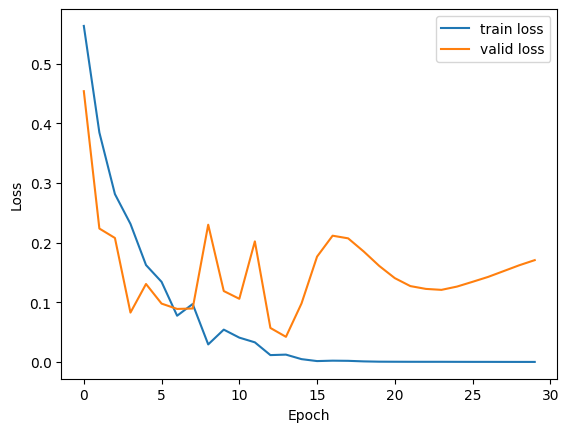

In [19]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_test_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
teacher_model = best_model
teacher_model.eval()

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (activation): ReLU()
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
  

In [21]:
student_model = TransformerModel(512, 2, 2, 0, 1024, .2, nn.ReLU(), 1).to(device)

In [22]:
optimizer = optim.Adam(student_model.parameters(), lr = 0.0001)
loss_func = nn.BCELoss()

In [23]:
best_loss = tc.inf 
best_model1 = [0]
train_hist_accuracy, train_hist_loss = [], []
valid_hist_accuracy, valid_hist_loss = [], []

In [24]:
N = 30
for i in range(N):

  student_model, train_loss, train_acc = train_one_epoch_kd(student_model, teacher_model, train_loader, loss_func_kd, optimizer, i)
  valid_loss, valid_acc = validation(student_model, valid_loader, loss_func)
  
  train_hist_accuracy.append(train_acc)
  train_hist_loss.append(train_loss)
  
  valid_hist_accuracy.append(valid_acc)
  valid_hist_loss.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model1[0] = student_model
    print('model saved!')

Epoch=0:   0%|          | 0/4 [00:00<?, ?batch/s]/tmp/ipykernel_11175/3061689171.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = nn.KLDivLoss(reduction = 'batchmean', log_target = False)(nn.LogSoftmax()(student_outputs/Tem),
/tmp/ipykernel_11175/3061689171.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax()(teacher_outputs/Tem)) * (alpha * (Tem ** 2)) +\
Epoch=0: 100%|██████████| 4/4 [00:02<00:00,  1.35batch/s, accuracy=79.5, loss=0.183]


valid loss=0.2931, accuracy=80.95

model saved!


Epoch=1: 100%|██████████| 4/4 [00:02<00:00,  1.38batch/s, accuracy=89, loss=0.0967] 


valid loss=0.09158, accuracy=100.0

model saved!


Epoch=2: 100%|██████████| 4/4 [00:02<00:00,  1.36batch/s, accuracy=94.5, loss=0.0772]


valid loss=0.1751, accuracy=90.48



Epoch=3: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s, accuracy=90.4, loss=0.12]  


valid loss=0.07697, accuracy=95.24

model saved!


Epoch=4: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s, accuracy=93.2, loss=0.0821]


valid loss=0.1582, accuracy=95.24



Epoch=5: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=93.2, loss=0.0488]


valid loss=0.1628, accuracy=95.24



Epoch=6: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s, accuracy=93.2, loss=0.0654]


valid loss=0.1223, accuracy=95.24



Epoch=7: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=98.6, loss=0.0223]


valid loss=0.1319, accuracy=95.24



Epoch=8: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=95.9, loss=0.039] 


valid loss=0.07884, accuracy=95.24



Epoch=9: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s, accuracy=98.6, loss=0.0117]


valid loss=0.05496, accuracy=100.0

model saved!


Epoch=10: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=98.6, loss=0.021] 


valid loss=0.04956, accuracy=100.0

model saved!


Epoch=11: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s, accuracy=98.6, loss=0.0151]


valid loss=0.1035, accuracy=95.24



Epoch=12: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=100, loss=0.00863]


valid loss=0.1352, accuracy=95.24



Epoch=13: 100%|██████████| 4/4 [00:02<00:00,  1.56batch/s, accuracy=100, loss=0.00303]


valid loss=0.08029, accuracy=95.24



Epoch=14: 100%|██████████| 4/4 [00:02<00:00,  1.52batch/s, accuracy=100, loss=0.00223]


valid loss=0.05924, accuracy=100.0



Epoch=15: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=100, loss=0.00279] 


valid loss=0.06028, accuracy=100.0



Epoch=16: 100%|██████████| 4/4 [00:02<00:00,  1.54batch/s, accuracy=100, loss=0.00156] 


valid loss=0.07585, accuracy=95.24



Epoch=17: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.000818]


valid loss=0.1233, accuracy=95.24



Epoch=18: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.000678]


valid loss=0.158, accuracy=95.24



Epoch=19: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=100, loss=0.000715]


valid loss=0.1704, accuracy=95.24



Epoch=20: 100%|██████████| 4/4 [00:02<00:00,  1.57batch/s, accuracy=100, loss=0.000577]


valid loss=0.158, accuracy=95.24



Epoch=21: 100%|██████████| 4/4 [00:02<00:00,  1.57batch/s, accuracy=100, loss=0.000395]


valid loss=0.1413, accuracy=95.24



Epoch=22: 100%|██████████| 4/4 [00:02<00:00,  1.57batch/s, accuracy=100, loss=0.000285]


valid loss=0.125, accuracy=95.24



Epoch=23: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.000255]


valid loss=0.1128, accuracy=95.24



Epoch=24: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.00022] 


valid loss=0.1069, accuracy=95.24



Epoch=25: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.000207]


valid loss=0.1046, accuracy=95.24



Epoch=26: 100%|██████████| 4/4 [00:02<00:00,  1.56batch/s, accuracy=100, loss=0.000194]


valid loss=0.107, accuracy=95.24



Epoch=27: 100%|██████████| 4/4 [00:02<00:00,  1.53batch/s, accuracy=100, loss=0.000165]


valid loss=0.1124, accuracy=95.24



Epoch=28: 100%|██████████| 4/4 [00:02<00:00,  1.55batch/s, accuracy=100, loss=0.000152]


valid loss=0.1189, accuracy=95.24



Epoch=29: 100%|██████████| 4/4 [00:02<00:00,  1.51batch/s, accuracy=100, loss=0.000136]


valid loss=0.1259, accuracy=95.24



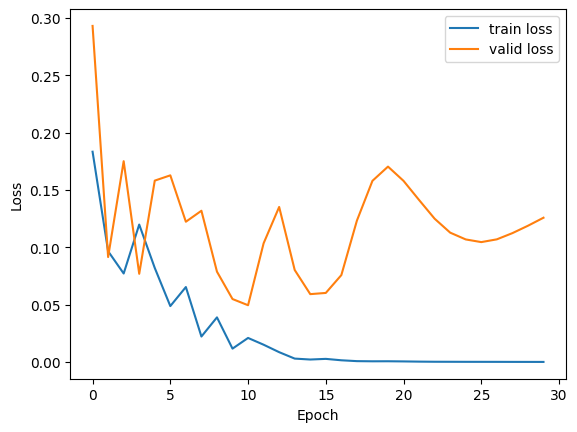

In [25]:
plt.plot(range(N), train_hist_loss, label = 'train loss')
plt.plot(range(N), valid_hist_loss, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()